In [79]:
import librosa

In [ ]:
import os
import time
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from models.conv_vae import ConvVAE
from readers.coughvid_reader import CoughVID_NormalAnomaly, CoughVID_Dataset
from readers.featurizer import Wave2Mel
from tools.utils import load_ckpt
from readers.collate_fn import collate_fn
from readers.audio import AudioSegment
from readers.featurizer import Wave2Mel
w2m = Wave2Mel(sr=16000)

# 测试集读取和测试

In [3]:
hp_list, hl_list, up_list, ul_list = CoughVID_NormalAnomaly(filename="./datasets/waveinfo_labeled_fine.csv", istrain=True, isdemo=False)
print(len(hp_list), len(up_list))
print(len(up_list), len(ul_list))
# 训练集取健康样本的13000个，剩下503个和非健康样本的503个一起组成验证集，测试集就是验证集。
vap, val = hp_list[13000:], hl_list[13000:]
vap.extend(up_list[:503])
val.extend(ul_list[:503])
print(len(vap), len(val))

13503 4173
4173 4173
1006 1006


In [4]:
tic = time.time()
valid_dataset = CoughVID_Dataset(path_list=vap, label_list=val)
toc = time.time()
print("Test Dataset Creat Completely, cost time:", toc-tic)

Loading:   0%|                                                                                | 0/1006 [00:00<?, ?it/s]C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\readers\audio.py:120: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading:   0%|                                                                        | 1/1006 [00:01<18:14,  1.09s/it]C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\readers\audio.py:120: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\sit

Test Dataset Creat Completely, cost time: 72.55080819129944


In [14]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [7]:
configs = {
    "run_save_dir": "./runs/tdnn_coughvid/",
    "model":{
        "num_class": 3,
        "input_length": 94,
        "wav_length": 48000,
        "input_dim": 512,
        "n_mels": 128,
        },
    "fit":{
        "batch_size": 64,
        "epochs" : 23,
        "start_scheduler_epoch": 6
        },
}
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
num_epoch = configs["fit"]["epochs"]
model = ConvVAE(shape=(1, configs["model"]["input_length"], configs["model"]["n_mels"]), flat=True).to(device)
load_epoch = 22
resume_path = f"./runs/tdnn_coughvid/202404261420_tdnn_focalloss/model_epoch_{load_epoch}"
state_dict = torch.load(os.path.join(resume_path, f'model_{load_epoch}.pth'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [75]:
show_path = random.choice(vap)
print(show_path)

F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/fecdab83-bcd4-4383-9b40-037a8d485746.webm


In [85]:
import IPython.display as ipd
ipd.Audio(show_path)

C:\Users\zhaoke\AppData\Local\Temp\ipykernel_28596\1123481044.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  s, r = librosa.load(show_path)


([], [])

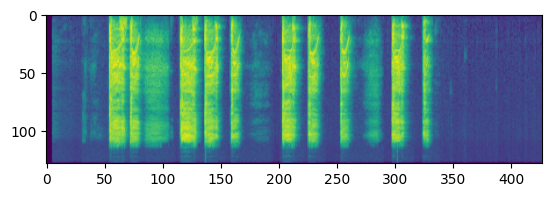

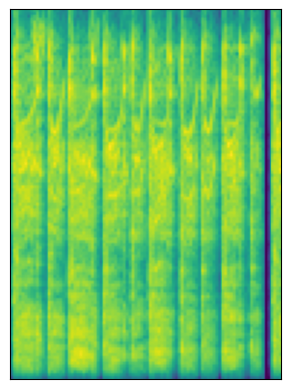

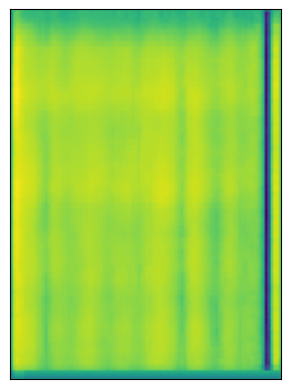

In [84]:
s, r = librosa.load(show_path)
plt.figure(2)
x_mel = w2m(torch.from_numpy(s))
plt.imshow(x_mel)
x_wav, y_label = torch.from_numpy(get_wav_label(show_path)).to(torch.float32).unsqueeze(0), val[x_idx]
# print("shape of x_wav", x_wav.shape)
x_mel = w2m(x_wav).transpose(1, 2).unsqueeze(1).to(device)
y_label = torch.tensor(y_label, device=device)
x_recon, _, _, _ = model(x=x_mel)

plt.figure(3)
x_recon = x_recon.squeeze().transpose(0,1).detach().cpu().numpy()
plt.imshow(x_mel.squeeze().transpose(0,1).detach().cpu().numpy())
plt.xticks([])
plt.yticks([])

plt.figure(4)
plt.imshow(x_recon)
plt.xticks([])
plt.yticks([])

# plt.show()

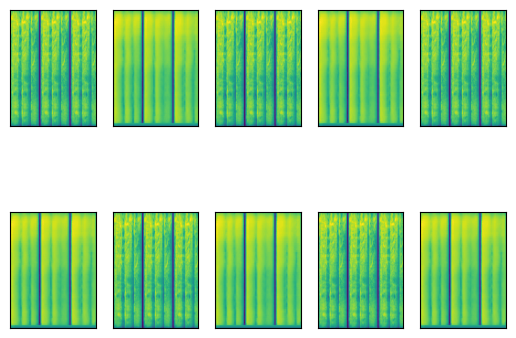

In [73]:
k=5
show_paths = random.choices(vap, k=k)
plt.figure(1)
idx = 0

for item in show_paths:
    x_wav, y_label = torch.from_numpy(get_wav_label(vap[x_idx])).to(torch.float32).unsqueeze(0), val[x_idx]
    # print("shape of x_wav", x_wav.shape)
    x_mel = w2m(x_wav).transpose(1, 2).unsqueeze(1).to(device)
    y_label = torch.tensor(y_label, device=device)
    # print("shape of x_mel", x_mel.shape)
    # break
    x_recon, _, _, _ = model(x=x_mel)
    x_recon = x_recon.squeeze().transpose(0,1).detach().cpu().numpy()
    plt.subplot(2, k, idx+1)
    plt.imshow(x_mel.squeeze().transpose(0,1).detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, k, idx+2)
    plt.imshow(x_recon)
    plt.xticks([])
    plt.yticks([])
    idx += 2
plt.savefig("./runs/tdnn_coughvid/202404261420_tdnn_focalloss/epoch22_recon.png", format="png", dpi=300)
plt.show()

In [35]:
model.eval()
tsne_input = []
loss_list = []
labels = []
# for x_idx, (x_wav, y_label, _) in enumerate(tqdm(test_loader, desc="Validate")):
for x_idx in tqdm(range(len(vap)), desc="Testing"):
    x_wav, y_label = torch.from_numpy(get_wav_label(vap[x_idx])).to(torch.float32).unsqueeze(0), val[x_idx]
    # print("shape of x_wav", x_wav.shape)
    x_mel = w2m(x_wav).transpose(1, 2).unsqueeze(1).to(device)
    y_label = torch.tensor(y_label, device=device)
    # print("shape of x_mel", x_mel.shape)
    # break
    recon_mel, z, mean_latent, logvar_latent = model(x=x_mel)
    # recon_loss = self.recon_loss(recon_spec, x_mel)
    pred_loss = vae_loss(x_mel, recon_mel, mean_latent, logvar_latent)
    
    # if x_idx == 0:
    tsne_input.append(z)
    labels.append(y_label)
    # else:
    #     tsne_input = torch.concat((tsne_input, z), dim=0)
    #     labels = torch.concat((labels, y_label), dim=0)
    loss_list.append(pred_loss.item())
    # if x_idx * configs["fit"]["batch_size"] > 800:
    #     break

Testing: 100%|█████████████████████████████████████████████████████████████████████| 1006/1006 [01:16<00:00, 13.22it/s]


In [36]:
print("tsne_input shape:", len(tsne_input))
print("loss_list shape:", len(loss_list))
print("lables shape:", len(labels))
# loss_list
# if epoch > 3:
#     self.plot_reduction(resume_path="", load_epoch=epoch, reducers=["heatmap"])
# heatmap_input = heatmap_input.detach().cpu().numpy()
# labels = labels.detach().cpu().numpy()
# calc_accuracy(pred_matrix=heatmap_input, label_vec=labels,
#               save_path=run_save_dir + f"/accuracy_epoch_{epoch_id}.txt")
# plot_heatmap(pred_matrix=heatmap_input, label_vec=labels,
#              ticks=["healthy", "symptomatic", "COVID-19"],
#              save_path=run_save_dir + f"/heatmap_epoch_{epoch_id}.png")

tsne_input shape: 1006
loss_list shape: 1006
lables shape: 1006


In [ ]:
tsne_matrix = torch.concat(tsne_input, dim=0)
print(tsne_matrix.shape)
tsne_matrix = tsne_matrix.detach().cpu().numpy()
tsne_matrix

In [ ]:
loss_list

In [ ]:
labels_list = torch.stack(labels, dim=0)
print(labels_list.shape)
labels_list = labels_list.detach().cpu().numpy()
labels_list

In [57]:
labels_list

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

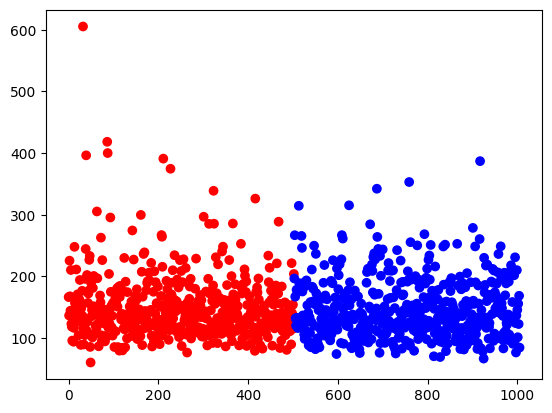

In [58]:
import matplotlib.pyplot as plt
cl = {0:"blue", 1:"red"}
plt.figure(0)
plt.scatter(range(len(loss_list)), loss_list, c=[cl[v] for v in labels_list])
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1006 samples in 0.001s...
[t-SNE] Computed neighbors for 1006 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1006
[t-SNE] Computed conditional probabilities for sample 1006 / 1006
[t-SNE] Mean sigma: 3.863256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.315674
[t-SNE] KL divergence after 300 iterations: 1.063154


C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\tools\plotter.py:52: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.scatterplot(


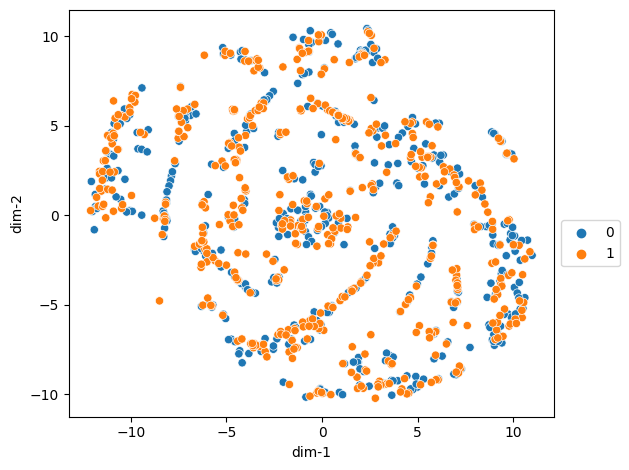

In [56]:
from tools.plotter import plot_tSNE
plot_tSNE(embd=tsne_matrix, names=labels_list, save_path="./runs/tdnn_coughvid/202404261420_tdnn_focalloss/epoch22_tsne.png")